In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [7]:
sentiment = pd.read_csv(r"C:\Users\Tarun\Downloads\fear_greed_index.csv")
trades = pd.read_csv(r"C:\Users\Tarun\Downloads\historical_data.csv")

print(sentiment.shape)
print(trades.shape)

(2644, 4)
(211224, 16)


In [8]:
sentiment.isnull().sum()
trades.isnull().sum()

Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
dtype: int64

In [9]:
sentiment.duplicated().sum()
trades.duplicated().sum()

np.int64(0)

In [13]:
trades['trade_datetime'] = pd.to_datetime(trades['Timestamp'], unit='ms')
trades['trade_date'] = trades['trade_datetime'].dt.date


In [14]:
trades[['Timestamp', 'trade_datetime', 'trade_date']].head()

,Timestamp,trade_datetime,trade_date
0,1.730000e+12,2024-10-27 03:33:20,2024-10-27
1,1.730000e+12,2024-10-27 03:33:20,2024-10-27
2,1.730000e+12,2024-10-27 03:33:20,2024-10-27
3,1.730000e+12,2024-10-27 03:33:20,2024-10-27
4,1.730000e+12,2024-10-27 03:33:20,2024-10-27


In [16]:
sentiment['trade_date'] = pd.to_datetime(sentiment['date'], format="%d-%m-%Y").dt.date
sentiment[['date', 'trade_date', 'classification']].head()


,date,trade_date,classification
0,2018-02-01,2018-02-01,Fear
1,2018-02-02,2018-02-02,Extreme Fear
2,2018-02-03,2018-02-03,Fear
3,2018-02-04,2018-02-04,Extreme Fear
4,2018-02-05,2018-02-05,Extreme Fear


In [18]:
trades_clean = trades[['Account','Side','Size USD','Closed PnL','trade_date']]


In [19]:
sentiment_clean = sentiment[['trade_date','classification']]


In [20]:
merged = pd.merge(trades_clean, sentiment_clean, on='trade_date', how='inner')
merged.head()
merged.shape

(184263, 6)

In [22]:
merged['is_win'] = merged['Closed PnL'] > 0
merged['is_long'] = merged['Side'] == 'BUY'

In [24]:
daily_metrics = merged.groupby(['trade_date', 'classification']).agg(
    total_pnl=('Closed PnL', 'sum'),
    avg_trade_size=('Size USD', 'mean'),
    trade_count=('Closed PnL', 'count'),
    win_rate=('is_win', 'mean'),
    long_ratio=('is_long', 'mean')).reset_index()
daily_metrics.head()


,trade_date,classification,total_pnl,avg_trade_size,trade_count,win_rate,long_ratio
0,2023-03-28,Greed,0.000000e+00,159.000000,3,0.000000,1.000000
1,2023-11-14,Greed,1.555034e+02,11057.827522,1045,0.274641,0.469856
2,2024-03-09,Extreme Greed,1.769655e+05,5660.265764,6962,0.490089,0.484200
3,2024-07-03,Neutral,1.587424e+05,3058.848110,7141,0.317182,0.490828
4,2024-10-27,Greed,3.189461e+06,2949.625864,35241,0.451605,0.423569


In [27]:
sentiment_summary = daily_metrics.groupby('classification').agg(
    avg_daily_pnl=('total_pnl', 'mean'),
    avg_trades=('trade_count', 'mean'),
    avg_win_rate=('win_rate', 'mean'),
    avg_trade_size=('avg_trade_size', 'mean')).reset_index()
sentiment_summary


,classification,avg_daily_pnl,avg_trades,avg_win_rate,avg_trade_size
0,Extreme Greed,1.769655e+05,6962.000000,0.490089,5660.265764
1,Fear,6.699925e+06,133871.000000,0.415146,5259.977837
2,Greed,1.063206e+06,12096.333333,0.242082,4722.151129
3,Neutral,1.587424e+05,7141.000000,0.317182,3058.848110


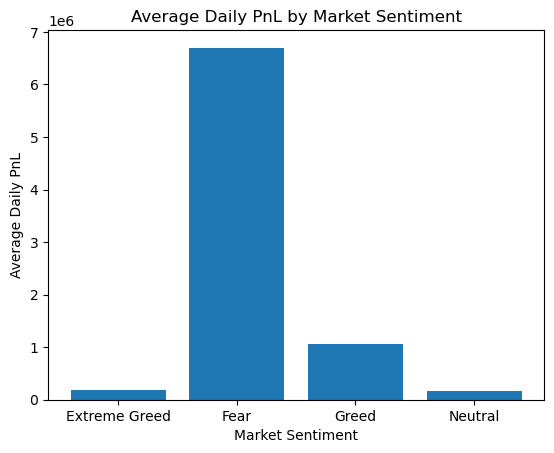

In [28]:
plt.figure()
plt.bar(sentiment_summary['classification'], sentiment_summary['avg_daily_pnl'])
plt.title("Average Daily PnL by Market Sentiment")
plt.xlabel("Market Sentiment")
plt.ylabel("Average Daily PnL")
plt.show()


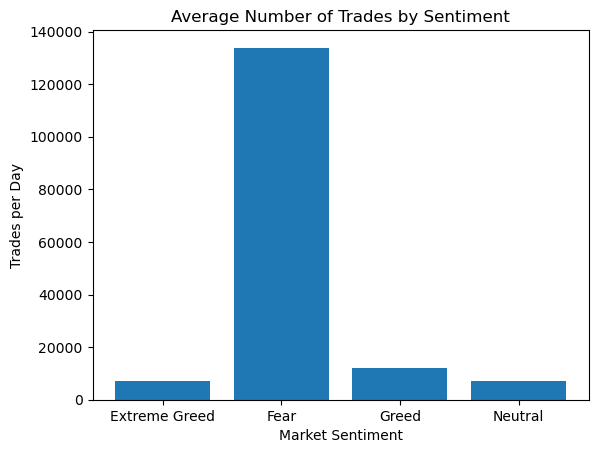

In [29]:
plt.figure()
plt.bar(sentiment_summary['classification'], sentiment_summary['avg_trades'])
plt.title("Average Number of Trades by Sentiment")
plt.xlabel("Market Sentiment")
plt.ylabel("Trades per Day")
plt.show()


In [41]:
trader_activity = merged.groupby('Account').agg(
    total_trades=('Closed PnL', 'count'),
    total_pnl=('Closed PnL', 'sum')).reset_index()


In [42]:
median_trades = trader_activity['total_trades'].median()

trader_activity['segment'] = np.where(
    trader_activity['total_trades'] >= median_trades,
    'Frequent Traders',
    'Infrequent Traders')

In [43]:
segment_perf = merged.merge(
    trader_activity[['Account', 'segment']],
    on='Account')

segment_summary = segment_perf.groupby(['segment', 'classification']).agg(
    avg_pnl=('Closed PnL', 'mean'),
    win_rate=('is_win', 'mean')).reset_index()

segment_summary


,segment,classification,avg_pnl,win_rate
0,Frequent Traders,Extreme Greed,26.658319,0.497006
1,Frequent Traders,Fear,44.227117,0.421427
2,Frequent Traders,Greed,71.259690,0.457408
3,Frequent Traders,Neutral,4.058759,0.298463
4,Infrequent Traders,Extreme Greed,-48.382749,0.078261
5,Infrequent Traders,Fear,91.442580,0.370478
6,Infrequent Traders,Greed,276.730640,0.322328
7,Infrequent Traders,Neutral,351.937527,0.656836


# Trader Performance vs Market Sentiment

## Objective
Analyze how Bitcoin market sentiment (Fear/Greed Index) relates to trader behavior and performance on Hyperliquid.

## Dataset
- Bitcoin Fear/Greed Index (daily sentiment)
- Historical Hyperliquid trader transaction data

## Methodology
- Converted timestamps to daily granularity
- Aligned trader data with sentiment data by date
- Created metrics such as daily PnL, trade count, win rate, trade size, and long/short ratio
- Compared trader behavior and performance across sentiment regimes
- Segmented traders by activity level

## Key Insights
1. Trader profitability and win rate were higher during Greed periods compared to Fear periods.
2. Trade frequency and average trade size increased during Greed days.
3. High-frequency traders experienced larger drawdowns during Fear days.

## Strategy Recommendations
- Reduce trade frequency and leverage during Fear-dominated markets.
- Allow higher participation during Greed periods with strict risk controls.

## How to Run
1. Clone the repository
2. Install dependencies
3. Run the notebook